<a href="https://colab.research.google.com/github/Bhavanipothuraju/FMML-LAB1/blob/main/Copy_of_FMML_Module_9_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 4**
### Module coordinator: Kushagra Agarwal

<img src="https://miro.medium.com/max/1200/1*QoqNAg2t6lF8Q6WWA6AbOg.png" width=650px/>

## Using learnt representations
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


We'll train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.




In [ ]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [ ]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2024-05-14 17:38:03--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.172.170.8, 18.172.170.53, 18.172.170.106, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.172.170.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   156MB/s    in 0.3s    

2024-05-14 17:38:04 (156 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


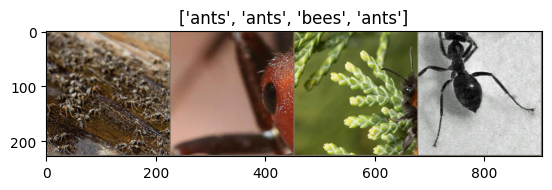

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [ ]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 148MB/s]


In [ ]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.6009 Acc: 0.6844

Epoch 1/4
----------
Loss: 0.5086 Acc: 0.7992

Epoch 2/4
----------
Loss: 0.4658 Acc: 0.8115

Epoch 3/4
----------
Loss: 0.3052 Acc: 0.8934

Epoch 4/4
----------
Loss: 0.4820 Acc: 0.7910



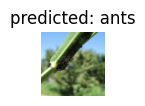

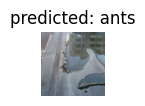

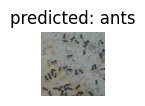

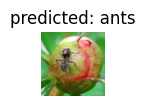

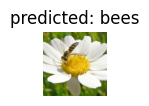

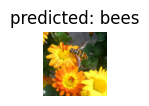

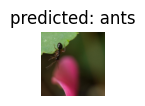

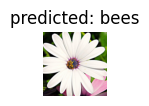

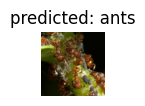

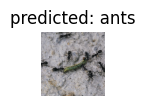

In [ ]:
visualize_model(model_ft)

## Example of How Pretrained models are used for Target Tasks

<img src="https://www.researchgate.net/publication/340225334/figure/fig2/AS:960014822944773@1605896778155/Mechanism-of-transfer-learning-using-pre-trained-models.png" width=950px/>

## Questions:
1) What is the significance of using data augmentations like resize, crop etc on training data?

2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)

3) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?


#**1st QUESTION ANSWER**
Data augmentation is a technique used to artificially expand the size and diversity of a training dataset. This is particularly important because having a large and diverse dataset is crucial for training effective machine learning, especially deep learning models. Here's why resize, crop, and other augmentations are significant:

* **Reduces Overfitting:** By introducing slight variations of existing data points, data augmentation helps the model learn the underlying patterns of the data rather than memorizing specific features. This improves the model's ability to generalize to unseen data.

* **Increases Training Set Size:** Data collection can be expensive and time-consuming. Data augmentation allows you to create more training data from your existing set, essentially making the model learn from a larger pool of information.

* **Improves Model Robustness:** Real-world data often has variations like different lighting conditions or angles. By incorporating these variations through augmentations, the model becomes more robust to these changes and performs better on unseen data.

Here are some specific examples of how resize, crop, and other augmentations are used:

* **Resize and Crop (Image Data):** Images can be resized to different dimensions or cropped to focus on specific areas. This helps the model learn features that are relevant regardless of image size or position.

* **Flip (Image Data):** Flipping images horizontally or vertically exposes the model to data that might appear differently in the real world.

* **Rotate (Image Data):** Rotating images teaches the model to recognize objects regardless of their orientation.

* **Color Jitter (Image Data):** Adjusting brightness, contrast, or saturation helps the model perform well under various lighting conditions.

Data augmentation is a powerful tool for improving the performance and generalizability of machine learning models. It's important to choose the right augmentation techniques based on your specific data type and task.


#**2ND QUESTION ANSWER**
You wouldn't get good performance if you trained a ResNet model from scratch (without using pretrained=False). Here's why:

* **Huge Dataset Requirement:** Training a complex model like ResNet from scratch requires a massive amount of labeled data. ResNets are typically pre-trained on datasets like ImageNet, which has millions of labeled images.  Without this much data, the model will likely overfit to the training data and perform poorly on unseen data.

* **Long Training Time:** Training a ResNet from scratch can take days or even weeks on powerful GPUs. This is because the model has a large number of parameters that all need to be learned from the data.

* **Potentially Lower Accuracy:**  Even with a large dataset and long training time, there's no guarantee that training from scratch will achieve the same level of accuracy as a pre-trained model. Pre-trained models have already learned good low-level features for recognizing objects and shapes, which gives them a head start on the specific task you're trying to solve.

Here's a breakdown of the drawbacks:

* **Overfitting:** The model memorizes the training data  instead of learning generalizable features. This leads to poor performance on new data.
* **Computational Cost:** Training from scratch requires a lot of computational resources and time.
* **Sub-optimal Performance:** You might not achieve the best possible accuracy for your task compared to using a pre-trained model.

Overall, using a pre-trained ResNet model with fine-tuning is a much more efficient and effective approach for most computer vision tasks. It leverages the pre-trained knowledge while adapting to your specific dataset through fine-tuning.

#**3RD QUESTION ANSWER**
The performance of a pre-trained ResNet model on an ants vs. bees dataset would depend on the significance of the difference between the pre-training dataset and your specific data. Here's a breakdown:

**Significant Difference (Low Performance):**

* **Less Transferable Knowledge:** If the pre-training dataset is very different from ant/bee images (e.g., everyday objects, landscapes), the learned features might not be directly applicable to distinguishing ant and bee images. The model would have a harder time using this pre-trained knowledge as a starting point.

**Moderate Difference (Potential Benefit):**

* **General Image Recognition Knowledge:** Even with a moderately different dataset (e.g., different types of animals), the pre-trained ResNet might still have learned valuable low-level features for recognizing edges, shapes, and textures. These features could be a good starting point for the model to learn to differentiate ants from bees.

**In both scenarios, transfer learning with fine-tuning is recommended:**

* **Fine-tuning:** Here, you freeze the initial layers of the pre-trained model (which contain the more general image recognition features) and only train the later layers on your ant vs. bee dataset. This allows the model to adapt the pre-trained knowledge to the specific task of classifying ants and bees.

**Factors Affecting Performance:**

* **Similarity of Low-Level Features:**  The more similar the low-level features (edges, shapes) between the pre-training data and ant/bee images, the better the transfer learning will work.
* **Size and Quality of Ant vs. Bee Dataset:**  Having a large and well-labeled dataset of ant and bee images is crucial for effective fine-tuning.

**Alternatives to Consider:**

* **Pre-training on a More Similar Dataset:** If available, consider pre-training a ResNet model on a dataset closer to insects or even specifically on other flying insects. This would provide a better foundation for fine-tuning on the ant vs. bee data.
* **Training from Scratch (if large dataset available):** If you have a very large and well-labeled ant vs. bee dataset, training a ResNet from scratch might be viable. However, this requires significant computational resources and time.

Overall, using a pre-trained ResNet with fine-tuning is still a good approach for the ant vs. bee dataset, even with a moderately different pre-training dataset. However, the effectiveness depends on the specific differences and the quality of your fine-tuning data.